In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras

import matplotlib.pyplot as plt
import time

import data_splitter as ds
import data_loader as dl
import run_model as rm
import eval_model as ev

2023-04-12 10:16:31.902983: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-12 10:16:33.423889: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import subprocess

try:
    subprocess.check_output('nvidia-smi')
    print('Nvidia GPU detected!')
except Exception: # this command not being found can raise quite a few different errors depending on the configuration
    print('No Nvidia GPU in system!')

Nvidia GPU detected!


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
KERASTUNER_TUNER_ID="chief"
KERASTUNER_ORACLE_IP="127.0.0.1"
KERASTUNER_ORACLE_PORT="8000"

In [3]:
splitter = ds.DataSplitter(verbose=True)

Total patient_id in training set:  9530
Total patient_id in test set:  2383
Total image_id in training set:  43767
Total image_id in test set:  10939
Total patient_id in training set:  7624
Total patient_id in calibration set:  1906
Total image_id in training set:  35003
Total image_id in calibration set:  8764


In [4]:
# splitter.trainset is the training set in format of {patient_id: [image_id, ...]}
train_ids = splitter.trainset.keys()
label_by_img = splitter.labels

# getting cross-validation folds from training set
RANDOM_STATE = 42
cv_patient, cv_img = splitter.get_cv(n_splits=5, random_state=RANDOM_STATE)

Splitting training set into 5 stratified k-folds...
--Fold:  0
----Total patient_id in training set:  6099
----Total image_id in training set:  28031
----Total patient_id in validation set:  1525
----Total image_id in validation set:  6972
--Fold:  1
----Total patient_id in training set:  6099
----Total image_id in training set:  28016
----Total patient_id in validation set:  1525
----Total image_id in validation set:  6987
--Fold:  2
----Total patient_id in training set:  6099
----Total image_id in training set:  27937
----Total patient_id in validation set:  1525
----Total image_id in validation set:  7066
--Fold:  3
----Total patient_id in training set:  6099
----Total image_id in training set:  28025
----Total patient_id in validation set:  1525
----Total image_id in validation set:  6978
--Fold:  4
----Total patient_id in training set:  6100
----Total image_id in training set:  28003
----Total patient_id in validation set:  1524
----Total image_id in validation set:  7000


In [5]:
metadata = pd.read_csv('train.csv')

# Trasfer learning from ImageNet

### Image Resolution 512 x 512

In [6]:
IMG_SIZE = (512, 512, 1)

inception = keras.applications.InceptionV3(
    weights='imagenet',  # load weights pre-trained on ImageNet.
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),  # should have exactly 3 inputs channels because it is pre-trained on RBG images
    include_top=False
    )

inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 255, 255, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 255, 255, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

                                                                                                  
 conv2d_10 (Conv2D)             (None, 61, 61, 96)   82944       ['activation_9[0][0]']           
                                                                                                  
 conv2d_11 (Conv2D)             (None, 61, 61, 32)   6144        ['average_pooling2d[0][0]']      
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 61, 61, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 61, 61, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
          

                                                                  'activation_14[0][0]',          
                                                                  'activation_17[0][0]',          
                                                                  'activation_18[0][0]']          
                                                                                                  
 conv2d_22 (Conv2D)             (None, 61, 61, 64)   18432       ['mixed1[0][0]']                 
                                                                                                  
 batch_normalization_22 (BatchN  (None, 61, 61, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 61, 61, 64)   0           ['batch_normalization_22[0][0]'] 
          

 ormalization)                                                                                    
                                                                                                  
 activation_26 (Activation)     (None, 30, 30, 384)  0           ['batch_normalization_26[0][0]'] 
                                                                                                  
 activation_29 (Activation)     (None, 30, 30, 96)   0           ['batch_normalization_29[0][0]'] 
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 30, 30, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 30, 30, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
          

 activation_39 (Activation)     (None, 30, 30, 192)  0           ['batch_normalization_39[0][0]'] 
                                                                                                  
 mixed4 (Concatenate)           (None, 30, 30, 768)  0           ['activation_30[0][0]',          
                                                                  'activation_33[0][0]',          
                                                                  'activation_38[0][0]',          
                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 30, 30, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 30, 30, 160)  480        ['conv2d_44[0][0]']              
 ormalizat

                                                                  'activation_49[0][0]']          
                                                                                                  
 conv2d_54 (Conv2D)             (None, 30, 30, 160)  122880      ['mixed5[0][0]']                 
                                                                                                  
 batch_normalization_54 (BatchN  (None, 30, 30, 160)  480        ['conv2d_54[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 30, 30, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 30, 30, 160)  179200      ['activation_54[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_64 (Activation)     (None, 30, 30, 192)  0           ['batch_normalization_64[0][0]'] 
                                                                                                  
 conv2d_65 (Conv2D)             (None, 30, 30, 192)  258048      ['activation_64[0][0]']          
                                                                                                  
 batch_normalization_65 (BatchN  (None, 30, 30, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 30, 30, 192)  0           ['batch_normalization_65[0][0]'] 
          

                                                                                                  
 batch_normalization_73 (BatchN  (None, 30, 30, 192)  576        ['conv2d_73[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_73 (Activation)     (None, 30, 30, 192)  0           ['batch_normalization_73[0][0]'] 
                                                                                                  
 conv2d_70 (Conv2D)             (None, 30, 30, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 30, 30, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_nor

 batch_normalization_83 (BatchN  (None, 14, 14, 384)  1152       ['conv2d_83[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_84 (Conv2D)             (None, 14, 14, 192)  245760      ['average_pooling2d_7[0][0]']    
                                                                                                  
 batch_normalization_76 (BatchN  (None, 14, 14, 320)  960        ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 14, 14, 384)  0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activatio

 ormalization)                                                                                    
                                                                                                  
 activation_87 (Activation)     (None, 14, 14, 384)  0           ['batch_normalization_87[0][0]'] 
                                                                                                  
 activation_88 (Activation)     (None, 14, 14, 384)  0           ['batch_normalization_88[0][0]'] 
                                                                                                  
 activation_91 (Activation)     (None, 14, 14, 384)  0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 14, 14, 384)  0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_nor

In [10]:
# base_model.summary()
keras.utils.plot_model(inception, show_shapes=True)

In [7]:
train_img_ids = cv_img[0]['train']
val_img_ids = cv_img[0]['validate']

In [8]:
BATCH_SIZE = 4*32 
IMG_SIZE = (512, 512, 1)
RANDOM_STATE = 42 # the random state that used to create cv splits

BASEPATH = '' # directory storing the preprocessed images of the training set

train_gen, val_gen = rm.get_train_val_generators(
        train_img_ids,
        val_img_ids,
        label_img_dict = splitter.labels,
        patient_img_dict = splitter.trainset,
    
        from_numpy=True,
        basepath=BASEPATH,
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,
    
        shuffle=True,
        normalize=(0, 1),
        feature_extractor='CNN',
        CNN_preprocess = keras.applications.inception_v3.preprocess_input
        )

In [10]:
print(len(train_gen), len(val_gen))

X, y = train_gen[0]
print(X.shape, y.shape)

218 54
(128, 512, 512, 3) (128,)


In [11]:
X, y = train_gen[0]
print(X.shape, y.shape)

(128, 512, 512, 3) (128,)


In [12]:
inception.output.shape[-3:]

TensorShape([14, 14, 2048])

## Out of the box

In [16]:
model_layers = keras.Sequential([
    keras.layers.Input(inception.output.shape[-3:]),
    keras.layers.GlobalAvgPool2D(),
    keras.layers.Dense(1, activation='sigmoid')
])

model_layers.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
_________________________________________________________________


In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [17]:
model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=False,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_imagenet_checkpoint/adam'
)

model.summary()

Checkpoint path:  models/inception_imagenet_checkpoint/adam
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 512, 512, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 14, 14, 2048)      21802784  
                                                                 
 sequential (Sequential)     (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [18]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_512_adam-lr-default-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    verbose = 1
    )

stop = time.time()
print('>>> Training time: ', (stop - start))  

Epoch 1/100


2023-04-07 06:35:39.835982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


218/218 [==============================] - ETA: 0s - loss: 0.1140 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27327.0000 - fn: 577.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4821 - prc: 0.0199

2023-04-07 06:56:04.008656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.13090, saving model to models/inception_imagenet_checkpoint/imagenet_512_adam-lr-default-01-prc0.02-tp0.0-loss0.13.hdf5
218/218 [==============================] - 1554s 7s/step - loss: 0.1140 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27327.0000 - fn: 577.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4821 - prc: 0.0199 - val_loss: 0.1309 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 6769.0000 - val_fn: 143.0000 - val_accuracy: 0.9793 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4583 - val_prc: 0.0178
Epoch 2/100
218/218 [==============================] - ETA: 0s - loss: 0.1010 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27326.0000 - fn: 578.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4805 - prc: 0.0198
Epoch 2: val_loss did not improve from 0.13090
218/218 [==============================] - 1549s 7s/step - loss: 0.1010 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2

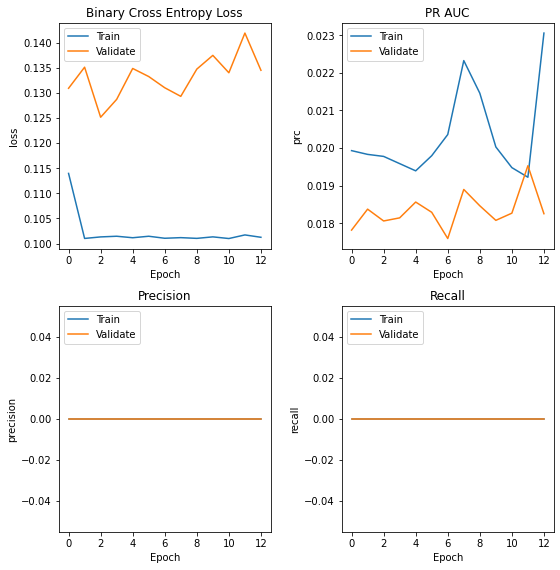

In [19]:
ev.plot_history(history)

## Use initial bias and class weights

In [9]:
pos = metadata[metadata.cancer==1].image_id.nunique()
neg = metadata[metadata.cancer==0].image_id.nunique()
initial_bias = np.log([pos/neg])
print(initial_bias)

[-3.83388407]


In [10]:
initial_bias = tf.keras.initializers.Constant()

model_layers = keras.Sequential([
    keras.layers.Input(inception.output.shape[-3:]),
    keras.layers.GlobalAvgPool2D(),
    keras.layers.Dense(1, activation='sigmoid', bias_initializer=initial_bias)
])

model_layers.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
_________________________________________________________________


In [11]:
pos = metadata[metadata.cancer==1].image_id.nunique()
neg = metadata[metadata.cancer==0].image_id.nunique()
total = metadata[metadata.patient_id.isin(splitter.trainset.keys())].image_id.nunique()

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.33
Weight for class 1: 15.11


In [15]:
model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=False,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics=METRICS,
    checkpoint_path='../predicitve_models/inception_imagenet_checkpoint/sgd'
)

model.summary()

Checkpoint path:  models/inception_imagenet_checkpoint/sgd
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 512, 512, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 14, 14, 2048)      21802784  
                                                                 
 sequential (Sequential)     (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [28]:
model.load_weights(
    '../predicitive_models/inception_imagenet_checkpoint/imagenet_512_bias_weight_adam-lr-default-06-prc0.02-tp0.0-loss0.30.hdf5'
)

In [ ]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_512_bias_weight_adam-lr-default-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )

stop = time.time()
print('>>> Training time: ', (stop - start))

Epoch 1/100


2023-04-07 23:46:40.740406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


218/218 [==============================] - ETA: 0s - loss: 0.4451 - tp: 262.0000 - fp: 12666.0000 - tn: 14658.0000 - fn: 318.0000 - accuracy: 0.5347 - precision: 0.0203 - recall: 0.4517 - auc: 0.4850 - prc: 0.0197

2023-04-08 00:08:42.778294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.39324, saving model to models/inception_imagenet_checkpoint/imagenet_512_bias_weight_adam-lr-default-01-prc0.02-tp0.0-loss0.39.hdf5
218/218 [==============================] - 1689s 8s/step - loss: 0.4451 - tp: 262.0000 - fp: 12666.0000 - tn: 14658.0000 - fn: 318.0000 - accuracy: 0.5347 - precision: 0.0203 - recall: 0.4517 - auc: 0.4850 - prc: 0.0197 - val_loss: 0.3932 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 6769.0000 - val_fn: 143.0000 - val_accuracy: 0.9793 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4707 - val_prc: 0.0181
Epoch 2/100
218/218 [==============================] - ETA: 0s - loss: 0.4424 - tp: 263.0000 - fp: 12025.0000 - tn: 15300.0000 - fn: 316.0000 - accuracy: 0.5577 - precision: 0.0214 - recall: 0.4542 - auc: 0.5122 - prc: 0.0216
Epoch 2: val_loss improved from 0.39324 to 0.38981, saving model to models/inception_imagenet_checkpoint/imagenet_512_bias_weight_adam-lr-default-02-prc0.02-tp0.0-loss0

In [29]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_512_bias_weight_adam-lr-default-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )

stop = time.time()
print('>>> Training time: ', (stop - start))

Epoch 1/100


2023-04-08 21:03:34.933596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


218/218 [==============================] - ETA: 0s - loss: 0.4437 - tp: 268.0000 - fp: 12404.0000 - tn: 14921.0000 - fn: 311.0000 - accuracy: 0.5443 - precision: 0.0211 - recall: 0.4629 - auc: 0.5094 - prc: 0.0217

2023-04-08 21:24:54.185038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.81729, saving model to models/inception_imagenet_checkpoint/imagenet_512_bias_weight_adam-lr-default-01-prc0.02-tp141.0-loss0.82.hdf5
218/218 [==============================] - 1601s 7s/step - loss: 0.4437 - tp: 268.0000 - fp: 12404.0000 - tn: 14921.0000 - fn: 311.0000 - accuracy: 0.5443 - precision: 0.0211 - recall: 0.4629 - auc: 0.5094 - prc: 0.0217 - val_loss: 0.8173 - val_tp: 141.0000 - val_fp: 6637.0000 - val_tn: 133.0000 - val_fn: 1.0000 - val_accuracy: 0.0396 - val_precision: 0.0208 - val_recall: 0.9930 - val_auc: 0.5405 - val_prc: 0.0238
Epoch 2/100
218/218 [==============================] - ETA: 0s - loss: 0.4415 - tp: 280.0000 - fp: 13288.0000 - tn: 14038.0000 - fn: 298.0000 - accuracy: 0.5131 - precision: 0.0206 - recall: 0.4844 - auc: 0.5061 - prc: 0.0204
Epoch 2: val_loss improved from 0.81729 to 0.29682, saving model to models/inception_imagenet_checkpoint/imagenet_512_bias_weight_adam-lr-default-02-prc0.02-tp0.0-loss0.30.hdf5
218

>>> Training time:  19082.711853265762


Process Keras_worker_ForkPoolWorker-1470:
Process Keras_worker_ForkPoolWorker-1471:
Process Keras_worker_ForkPoolWorker-1465:
Process Keras_worker_ForkPoolWorker-1460:
Process Keras_worker_ForkPoolWorker-1467:
Process Keras_worker_ForkPoolWorker-1455:
Process Keras_worker_ForkPoolWorker-1457:
Process Keras_worker_ForkPoolWorker-1469:
Process Keras_worker_ForkPoolWorker-1450:
Process Keras_worker_ForkPoolWorker-1453:
Process Keras_worker_ForkPoolWorker-1468:
Process Keras_worker_ForkPoolWorker-1449:
Process Keras_worker_ForkPoolWorker-1454:
Process Keras_worker_ForkPoolWorker-1472:
Process Keras_worker_ForkPoolWorker-1459:
Traceback (most recent call last):
Traceback (most recent call last):
Process Keras_worker_ForkPoolWorker-1456:
Process Keras_worker_ForkPoolWorker-1464:
Process Keras_worker_ForkPoolWorker-1466:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process Keras_worker_ForkPoolWorker-1451:
Process Keras_worker_ForkPo

  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/sw/pkgs/arc/python3.9-an

  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/queues.py", line 365, in get
    with self._rlock:
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/queues.py", line 365, in get
    with self._rlock:
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/queues.py", line 365, in get
    with self._rlock:
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/pyt

  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/connection.py", line 384, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt


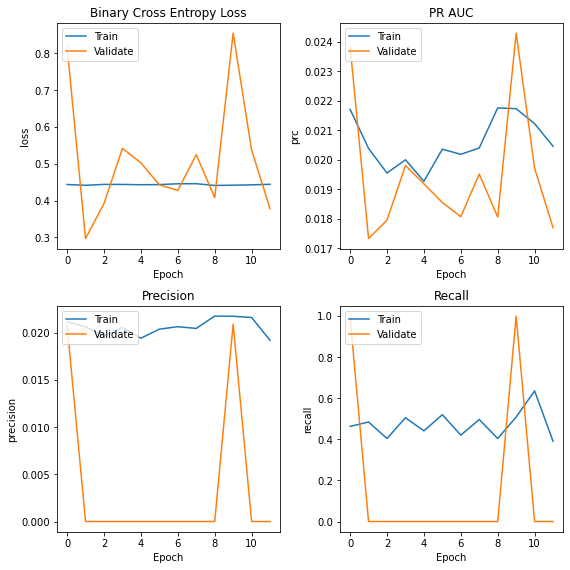

In [31]:
ev.plot_history(history)

### Increase learning rate

In [20]:
LEARNING_RATE = 0.01
model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=False,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=METRICS,
    checkpoint_path='./predictive_models/inception_imagenet_checkpoint/adam'
)

model.summary()

Checkpoint path:  models/inception_imagenet_checkpoint/adam
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 512, 512, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 14, 14, 2048)      21802784  
                                                                 
 sequential (Sequential)     (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [21]:
start = time.time()

EPOCH = 30

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_512_bias_weights_adam-lr1e-2-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 40,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )

stop = time.time()
print('>>> Training time: ', (stop - start))  

Epoch 1/30


2023-04-09 02:46:42.025374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]
2023-04-09 02:46:54.922768: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700


875/875 [==============================] - ETA: 0s - loss: 0.5469 - tp: 280.0000 - fp: 13640.0000 - tn: 13779.0000 - fn: 301.0000 - accuracy: 0.5021 - precision: 0.0201 - recall: 0.4819 - auc: 0.4848 - prc: 0.0197

2023-04-09 02:55:17.841664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.37822, saving model to models/inception_imagenet_checkpoint/imagenet_512_bias_weights_adam-lr1e-2-01-prc0.02-tp0.0-loss0.38.hdf5
875/875 [==============================] - 673s 752ms/step - loss: 0.5469 - tp: 280.0000 - fp: 13640.0000 - tn: 13779.0000 - fn: 301.0000 - accuracy: 0.5021 - precision: 0.0201 - recall: 0.4819 - auc: 0.4848 - prc: 0.0197 - val_loss: 0.3782 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 6802.0000 - val_fn: 142.0000 - val_accuracy: 0.9796 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4848 - val_prc: 0.0195
Epoch 2/30
875/875 [==============================] - ETA: 0s - loss: 0.5575 - tp: 287.0000 - fp: 13601.0000 - tn: 13818.0000 - fn: 294.0000 - accuracy: 0.5038 - precision: 0.0207 - recall: 0.4940 - auc: 0.5081 - prc: 0.0214
Epoch 2: val_loss did not improve from 0.37822
875/875 [==============================] - 680s 763ms/step - loss: 0.5575 - tp: 287.0000 - fp: 13601.0000 - tn: 13818.0000 

Epoch 13/30
875/875 [==============================] - ETA: 0s - loss: 0.5353 - tp: 291.0000 - fp: 13693.0000 - tn: 13727.0000 - fn: 289.0000 - accuracy: 0.5006 - precision: 0.0208 - recall: 0.5017 - auc: 0.5038 - prc: 0.0208
Epoch 13: val_loss improved from 0.12372 to 0.10704, saving model to models/inception_imagenet_checkpoint/imagenet_512_bias_weights_adam-lr1e-2-13-prc0.02-tp0.0-loss0.11.hdf5
875/875 [==============================] - 696s 782ms/step - loss: 0.5353 - tp: 291.0000 - fp: 13693.0000 - tn: 13727.0000 - fn: 289.0000 - accuracy: 0.5006 - precision: 0.0208 - recall: 0.5017 - auc: 0.5038 - prc: 0.0208 - val_loss: 0.1070 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 6800.0000 - val_fn: 144.0000 - val_accuracy: 0.9793 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4491 - val_prc: 0.0179
Epoch 14/30
875/875 [==============================] - ETA: 0s - loss: 0.5594 - tp: 283.0000 - fp: 13637.0000 - tn: 13782.0000 - fn: 298.0000 - accuracy: 0.5023 - pr

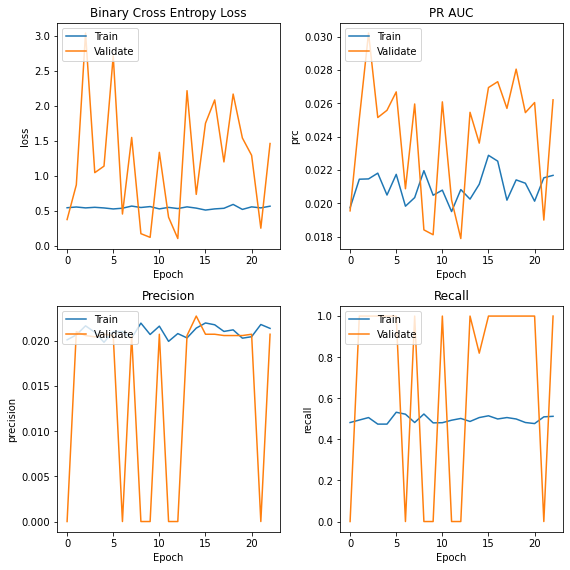

In [22]:
ev.plot_history(history)

### Decreasing learning rate

In [16]:
%load_ext tensorboard

In [17]:
from keras.callbacks import TensorBoard
import os

log_basepath = '../logs_'
model_name = 'imagenet_512_bias_weight_adam-lr-1e-5'

model_log_path = log_basepath + model_name
os.makedirs(model_log_path, exist_ok=True)

tensorboard = TensorBoard(
    log_dir=model_log_path,
    histogram_freq=1,
    write_graph=True,
    write_images=False,
    update_freq='epoch'
)

In [12]:
LEARNING_RATE = 0.00001
model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=False,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_imagenet_checkpoint/adam'
)

model.summary()

Checkpoint path:  models/inception_imagenet_checkpoint/adam
---Checkpoint folder created:  models/inception_imagenet_checkpoint/adam
Creating a new model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 512, 512, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 14, 14, 2048)      21802784  
                                                                 
 sequential (Sequential)     (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
start = time.time()

EPOCH = 100
CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_512_bias_weights_adamlr1e-5-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)
early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[checkpoint, early_stopping, tensorboard],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )

stop = time.time()
print('>>> Training time: ', (stop - start))  

Epoch 1/100


2023-04-09 07:25:52.695640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


875/875 [==============================] - ETA: 0s - loss: 0.4442 - tp: 724.0000 - fp: 34220.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.0207 - precision: 0.0207 - recall: 1.0000 - auc: 0.4930 - prc: 0.0215

2023-04-09 07:34:31.789947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 1.03346, saving model to models/inception_imagenet_checkpoint/imagenet_bias_weights_adamlr1e-5-01-prc0.03-tp144.0-loss1.03.hdf5
875/875 [==============================] - 688s 770ms/step - loss: 0.4442 - tp: 724.0000 - fp: 34220.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.0207 - precision: 0.0207 - recall: 1.0000 - auc: 0.4930 - prc: 0.0215 - val_loss: 1.0335 - val_tp: 144.0000 - val_fp: 6799.0000 - val_tn: 1.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.0209 - val_precision: 0.0207 - val_recall: 1.0000 - val_auc: 0.5675 - val_prc: 0.0254
Epoch 2/100
875/875 [==============================] - ETA: 0s - loss: 0.4397 - tp: 507.0000 - fp: 24197.0000 - tn: 3222.0000 - fn: 74.0000 - accuracy: 0.1332 - precision: 0.0205 - recall: 0.8726 - auc: 0.4829 - prc: 0.0196
Epoch 2: val_loss improved from 1.03346 to 0.94826, saving model to models/inception_imagenet_checkpoint/imagenet_bias_weights_adamlr1e-5-02-prc0.03-tp143.0-loss0.95.hdf5
875/875 [====

875/875 [==============================] - ETA: 0s - loss: 0.4386 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27421.0000 - fn: 579.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4880 - prc: 0.0196
Epoch 23: val_loss did not improve from 0.89745
875/875 [==============================] - 692s 779ms/step - loss: 0.4386 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27421.0000 - fn: 579.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4880 - prc: 0.0196 - val_loss: 0.9378 - val_tp: 144.0000 - val_fp: 6785.0000 - val_tn: 15.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.0229 - val_precision: 0.0208 - val_recall: 1.0000 - val_auc: 0.5626 - val_prc: 0.0250
Epoch 24/100
875/875 [==============================] - ETA: 0s - loss: 0.4393 - tp: 202.0000 - fp: 9494.0000 - tn: 17925.0000 - fn: 379.0000 - accuracy: 0.6474 - precision: 0.0208 - recall: 0.3477 - auc: 0.4846 - prc: 0.0195
Epoch 24: val_loss did not improve from 0.89745
875/875 [============

In [20]:
start = time.time()

EPOCH = 100
CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_512_bias_weights_adamlr1e-5-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)
early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[checkpoint, early_stopping, tensorboard],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )

stop = time.time()
print('>>> Training time: ', (stop - start)) 

2023-04-10 00:00:03.297278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


Epoch 1/100
218/218 [==============================] - ETA: 0s - loss: 0.4409 - tp: 579.0000 - fp: 27325.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.0207 - precision: 0.0207 - recall: 1.0000 - auc: 0.4887 - prc: 0.0204

2023-04-10 00:21:42.138684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.81101, saving model to models/inception_imagenet_checkpoint/imagenet_512_bias_weights_adamlr1e-5-01-prc0.02-tp135.0-loss0.81.hdf5
218/218 [==============================] - 1633s 7s/step - loss: 0.4409 - tp: 579.0000 - fp: 27325.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.0207 - precision: 0.0207 - recall: 1.0000 - auc: 0.4887 - prc: 0.0204 - val_loss: 0.8110 - val_tp: 135.0000 - val_fp: 6353.0000 - val_tn: 416.0000 - val_fn: 8.0000 - val_accuracy: 0.0797 - val_precision: 0.0208 - val_recall: 0.9441 - val_auc: 0.4792 - val_prc: 0.0192
Epoch 2/100
218/218 [==============================] - ETA: 0s - loss: 0.4399 - tp: 580.0000 - fp: 27324.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.0208 - precision: 0.0208 - recall: 1.0000 - auc: 0.5060 - prc: 0.0210
Epoch 2: val_loss improved from 0.81101 to 0.76415, saving model to models/inception_imagenet_checkpoint/imagenet_512_bias_weights_adamlr1e-5-02-prc0.02-tp111.0-loss0.76.hdf5
218/2

Epoch 12/100
218/218 [==============================] - ETA: 0s - loss: 0.4389 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27326.0000 - fn: 578.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4888 - prc: 0.0202
Epoch 12: val_loss did not improve from 0.72235
218/218 [==============================] - 1595s 7s/step - loss: 0.4389 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27326.0000 - fn: 578.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4888 - prc: 0.0202 - val_loss: 0.7251 - val_tp: 88.0000 - val_fp: 4328.0000 - val_tn: 2440.0000 - val_fn: 56.0000 - val_accuracy: 0.3657 - val_precision: 0.0199 - val_recall: 0.6111 - val_auc: 0.4669 - val_prc: 0.0187
Epoch 13/100
218/218 [==============================] - ETA: 0s - loss: 0.4393 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27325.0000 - fn: 579.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4808 - prc: 0.0194
Epoch 13: val_loss did not improve from 0.72235
2

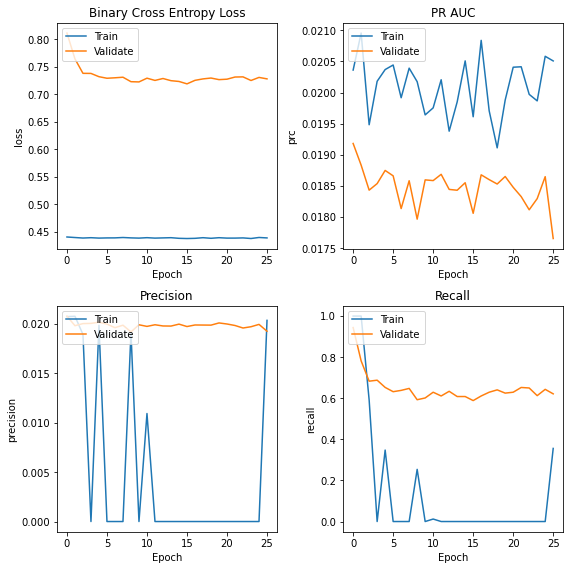

In [23]:
ev.plot_history(history)

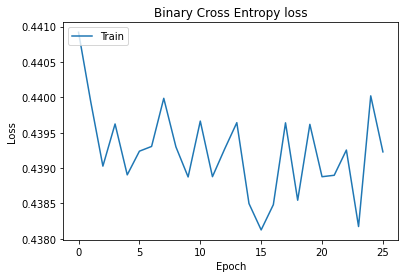

In [24]:
plt.plot(history.history['loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

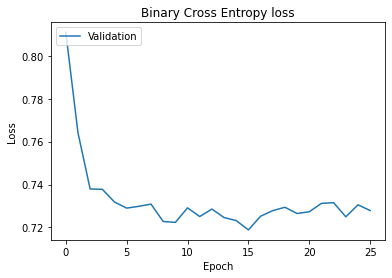

In [26]:
plt.plot(history.history['val_loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validation'], loc='upper left')
plt.show()

### Freeze and save weights from epoch 16 which has the lowest validation loss for predictions

In [13]:
model.load_weights('../predictive_models/inception_imagenet_checkpoint/selected_models/imagenet_512_bias_weights_adamlr1e-5-16-prc0.02-tp83.0-loss0.72.hdf5')

model.trainable = False
model.save('../predictive_models/inception_imagenet_checkpoint/selected_models/imagenet_512_batch128_adam_lr1e-5_epoch16_frozen.hdf5')

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 512, 512, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 14, 14, 2048)      21802784  
                                                                 
 sequential (Sequential)     (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 0
Non-trainable params: 21,804,833
_________________________________________________________________


### Reducing batch size from 4 x 32 to 2 x 32

In [18]:
BATCH_SIZE = 2*32 
IMG_SIZE = (512, 512, 1)
RANDOM_STATE = 42 # the random state that used to create cv splits

BASEPATH = '' # directory storing the preprocessed images of the training set

train_gen, val_gen = rm.get_train_val_generators(
        train_img_ids,
        val_img_ids,
        label_img_dict = splitter.labels,
        patient_img_dict = splitter.trainset,
    
        from_numpy=True,
        basepath=BASEPATH,
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,

        shuffle=True,
        normalize=(0, 1),
        feature_extractor='CNN',
        CNN_preprocess = keras.applications.inception_v3.preprocess_input
        )

In [20]:
LEARNING_RATE = 0.00001
model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=False,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_imagenet_checkpoint/adam'
)

model.summary()

Checkpoint path:  models/inception_imagenet_checkpoint/adam
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 512, 512, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 14, 14, 2048)      21802784  
                                                                 
 sequential (Sequential)     (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [21]:
model.load_weights('../predictive_models/inception_imagenet_checkpoint/imagenet_512_bias_weights_adamlr1e-5-16-prc0.02-tp83.0-loss0.72.hdf5')

In [23]:
start = time.time()

EPOCH = 100
CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_512_bias_weights_batch64_adam-lr1e-5-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)
early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[checkpoint, early_stopping],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )

stop = time.time()
print('>>> Training time: ', (stop - start)) 

Epoch 1/100


2023-04-10 12:41:04.540199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]
2023-04-10 12:41:31.217415: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700


437/437 [==============================] - ETA: 0s - loss: 0.4388 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27389.0000 - fn: 579.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4965 - prc: 0.0206

2023-04-10 12:50:25.775974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.73233, saving model to models/inception_imagenet_checkpoint/imagenet_512_bias_weights_batch64_adam-lr1e-5-01-prc0.02-tp94.0-loss0.73.hdf5
437/437 [==============================] - 760s 2s/step - loss: 0.4388 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27389.0000 - fn: 579.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4965 - prc: 0.0206 - val_loss: 0.7323 - val_tp: 94.0000 - val_fp: 4583.0000 - val_tn: 2185.0000 - val_fn: 50.0000 - val_accuracy: 0.3297 - val_precision: 0.0201 - val_recall: 0.6528 - val_auc: 0.4679 - val_prc: 0.0187
Epoch 2/100
437/437 [==============================] - ETA: 0s - loss: 0.4395 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27387.0000 - fn: 581.0000 - accuracy: 0.9792 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4972 - prc: 0.0207
Epoch 2: val_loss did not improve from 0.73233
437/437 [==============================] - 755s 2s/step - loss: 0.4395 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn

Epoch 13/100
437/437 [==============================] - ETA: 0s - loss: 0.4392 - tp: 76.0000 - fp: 4148.0000 - tn: 23240.0000 - fn: 504.0000 - accuracy: 0.8337 - precision: 0.0180 - recall: 0.1310 - auc: 0.4846 - prc: 0.0198
Epoch 13: val_loss did not improve from 0.71641
437/437 [==============================] - 789s 2s/step - loss: 0.4392 - tp: 76.0000 - fp: 4148.0000 - tn: 23240.0000 - fn: 504.0000 - accuracy: 0.8337 - precision: 0.0180 - recall: 0.1310 - auc: 0.4846 - prc: 0.0198 - val_loss: 0.7208 - val_tp: 85.0000 - val_fp: 4181.0000 - val_tn: 2589.0000 - val_fn: 57.0000 - val_accuracy: 0.3869 - val_precision: 0.0199 - val_recall: 0.5986 - val_auc: 0.4686 - val_prc: 0.0184
Epoch 14/100
437/437 [==============================] - ETA: 0s - loss: 0.4384 - tp: 0.0000e+00 - fp: 128.0000 - tn: 27262.0000 - fn: 578.0000 - accuracy: 0.9748 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4776 - prc: 0.0192
Epoch 14: val_loss did not improve from 0.71641
437/437 [===================

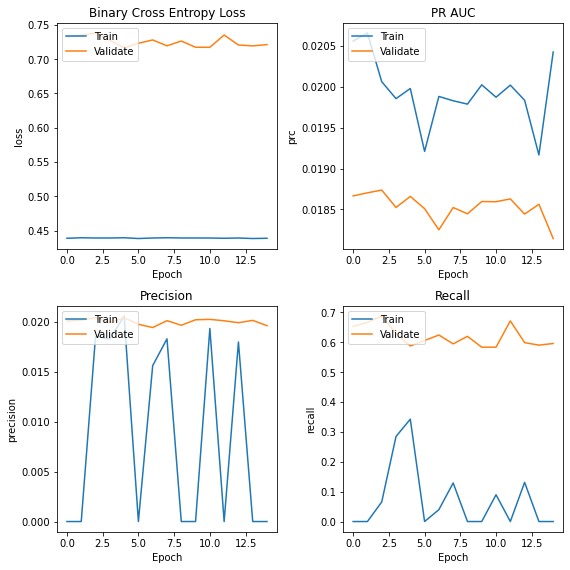

In [24]:
ev.plot_history(history)

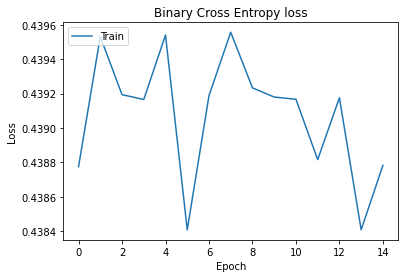

In [26]:
plt.plot(history.history['loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

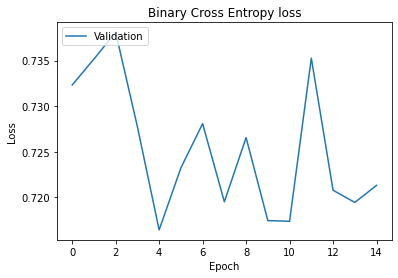

In [27]:
plt.plot(history.history['val_loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validation'], loc='upper left')
plt.show()

### Increasing batch size from 4 x 32 to 8 x 32

In [16]:
BATCH_SIZE = 8*32 
IMG_SIZE = (512, 512, 1)
RANDOM_STATE = 42 # the random state that used to create cv splits

BASEPATH = '' # directory storing the preprocessed images of the training set

train_gen, val_gen = rm.get_train_val_generators(
        train_img_ids,
        val_img_ids,
        label_img_dict = splitter.labels,
        patient_img_dict = splitter.trainset,
    
        from_numpy=True,
        basepath=BASEPATH,
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,

        shuffle=True,
        normalize=(0, 1),
        feature_extractor='CNN',
        CNN_preprocess = keras.applications.inception_v3.preprocess_input
        )

In [17]:
LEARNING_RATE = 0.00001
model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=False,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_imagenet_checkpoint/adam'
)

model.summary()

Checkpoint path:  models/inception_imagenet_checkpoint/adam
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 512, 512, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 14, 14, 2048)      21802784  
                                                                 
 sequential (Sequential)     (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [18]:
model.load_weights('../predictive_models/inception_imagenet_checkpoint/imagenet_512_bias_weights_adamlr1e-5-16-prc0.02-tp83.0-loss0.72.hdf5')

In [19]:
start = time.time()

EPOCH = 100
CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_512_bias_weights_batch256_adam-lr1e-5-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)
early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[checkpoint, early_stopping],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )

stop = time.time()
print('>>> Training time: ', (stop - start)) 

Epoch 1/100


2023-04-10 23:27:13.454140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


109/109 [==============================] - ETA: 0s - loss: 0.4396 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27324.0000 - fn: 580.0000 - accuracy: 0.9792 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4792 - prc: 0.0197 

2023-04-10 23:51:14.527039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.72166, saving model to models/inception_imagenet_checkpoint/imagenet_512_bias_weights_batch256_adam-lr1e-5-01-prc0.02-tp85.0-loss0.72.hdf5
109/109 [==============================] - 1914s 17s/step - loss: 0.4396 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27324.0000 - fn: 580.0000 - accuracy: 0.9792 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4792 - prc: 0.0197 - val_loss: 0.7217 - val_tp: 85.0000 - val_fp: 4214.0000 - val_tn: 2555.0000 - val_fn: 58.0000 - val_accuracy: 0.3819 - val_precision: 0.0198 - val_recall: 0.5944 - val_auc: 0.4653 - val_prc: 0.0184
Epoch 2/100
109/109 [==============================] - ETA: 0s - loss: 0.4392 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27325.0000 - fn: 579.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0207 
Epoch 2: val_loss did not improve from 0.72166
109/109 [==============================] - 1870s 17s/step - loss: 0.4392 - tp: 0.0000e+00 - fp: 0.0000e+0

109/109 [==============================] - 1874s 17s/step - loss: 0.4382 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27328.0000 - fn: 576.0000 - accuracy: 0.9794 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4893 - prc: 0.0199 - val_loss: 0.7202 - val_tp: 86.0000 - val_fp: 4158.0000 - val_tn: 2611.0000 - val_fn: 57.0000 - val_accuracy: 0.3902 - val_precision: 0.0203 - val_recall: 0.6014 - val_auc: 0.4701 - val_prc: 0.0186
Epoch 13/100
109/109 [==============================] - ETA: 0s - loss: 0.4385 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27327.0000 - fn: 577.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4877 - prc: 0.0200 
Epoch 13: val_loss did not improve from 0.72016
109/109 [==============================] - 1804s 16s/step - loss: 0.4385 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27327.0000 - fn: 577.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4877 - prc: 0.0200 - val_loss: 0.7216 - val_tp: 85.0000 - val_fp: 4211.0

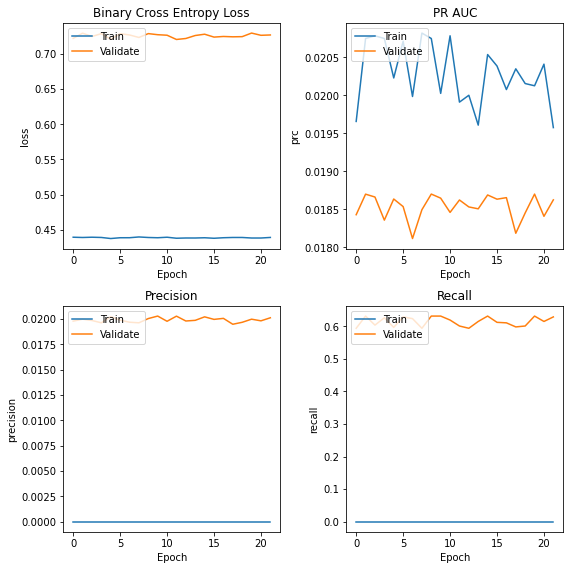

In [20]:
ev.plot_history(history)

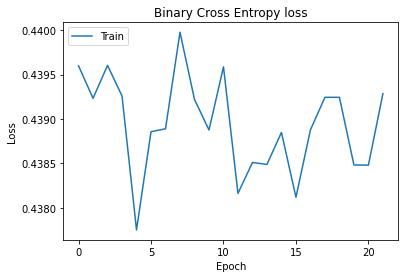

In [21]:
plt.plot(history.history['loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

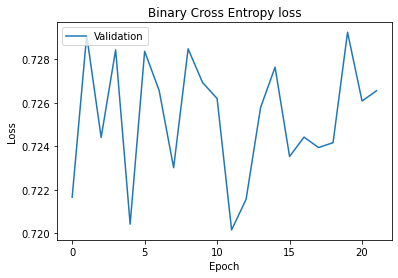

In [22]:
plt.plot(history.history['val_loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validation'], loc='upper left')
plt.show()

### Decrease batch size to 2 x 32 and increase learning rate to 0.00005

In [14]:
BATCH_SIZE = 2*32 
IMG_SIZE = (512, 512, 1)
RANDOM_STATE = 42 # the random state that used to create cv splits

BASEPATH = '' # directory storing the preprocessed images of the training set

train_gen, val_gen = rm.get_train_val_generators(
        train_img_ids,
        val_img_ids,
        label_img_dict = splitter.labels,
        patient_img_dict = splitter.trainset,
    
        from_numpy=True,
        basepath=BASEPATH,
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,
    
        shuffle=True,
        normalize=(0, 1),
        feature_extractor='CNN',
        CNN_preprocess = keras.applications.inception_v3.preprocess_input
        )

In [15]:
LEARNING_RATE = 0.00005
model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=False,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_imagenet_checkpoint/adam'
)

model.summary()

Checkpoint path:  models/inception_imagenet_checkpoint/adam
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 512, 512, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 14, 14, 2048)      21802784  
                                                                 
 sequential (Sequential)     (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [16]:
start = time.time()

EPOCH = 100
CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_512_bias_weights_batch64_adam-lr5e-5-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)
early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[checkpoint, early_stopping],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )

stop = time.time()
print('>>> Training time: ', (stop - start)) 

2023-04-11 11:16:00.966719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


Epoch 1/100


2023-04-11 11:16:20.336808: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700


437/437 [==============================] - ETA: 0s - loss: 0.4394 - tp: 372.0000 - fp: 17932.0000 - tn: 9457.0000 - fn: 207.0000 - accuracy: 0.3514 - precision: 0.0203 - recall: 0.6425 - auc: 0.4888 - prc: 0.0198

2023-04-11 11:25:01.692222: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.81399, saving model to models/inception_imagenet_checkpoint/imagenet_512_bias_weights_batch64_adam-lr5e-5-01-prc0.02-tp135.0-loss0.81.hdf5
437/437 [==============================] - 734s 2s/step - loss: 0.4394 - tp: 372.0000 - fp: 17932.0000 - tn: 9457.0000 - fn: 207.0000 - accuracy: 0.3514 - precision: 0.0203 - recall: 0.6425 - auc: 0.4888 - prc: 0.0198 - val_loss: 0.8140 - val_tp: 135.0000 - val_fp: 6253.0000 - val_tn: 515.0000 - val_fn: 9.0000 - val_accuracy: 0.0940 - val_precision: 0.0211 - val_recall: 0.9375 - val_auc: 0.5198 - val_prc: 0.0217
Epoch 2/100
437/437 [==============================] - ETA: 0s - loss: 0.4393 - tp: 33.0000 - fp: 2207.0000 - tn: 25182.0000 - fn: 546.0000 - accuracy: 0.9016 - precision: 0.0147 - recall: 0.0570 - auc: 0.4627 - prc: 0.0185
Epoch 2: val_loss did not improve from 0.81399
437/437 [==============================] - 709s 2s/step - loss: 0.4393 - tp: 33.0000 - fp: 2207.0000 - tn: 25182.0000 - fn: 546.0000

Epoch 13/100
437/437 [==============================] - ETA: 0s - loss: 0.4398 - tp: 271.0000 - fp: 12273.0000 - tn: 15114.0000 - fn: 310.0000 - accuracy: 0.5501 - precision: 0.0216 - recall: 0.4664 - auc: 0.5004 - prc: 0.0204
Epoch 13: val_loss did not improve from 0.79755
437/437 [==============================] - 710s 2s/step - loss: 0.4398 - tp: 271.0000 - fp: 12273.0000 - tn: 15114.0000 - fn: 310.0000 - accuracy: 0.5501 - precision: 0.0216 - recall: 0.4664 - auc: 0.5004 - prc: 0.0204 - val_loss: 0.8882 - val_tp: 143.0000 - val_fp: 6716.0000 - val_tn: 53.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.0284 - val_precision: 0.0208 - val_recall: 1.0000 - val_auc: 0.5248 - val_prc: 0.0218
Epoch 14/100
437/437 [==============================] - ETA: 0s - loss: 0.4397 - tp: 262.0000 - fp: 12474.0000 - tn: 14914.0000 - fn: 318.0000 - accuracy: 0.5426 - precision: 0.0206 - recall: 0.4517 - auc: 0.4915 - prc: 0.0202
Epoch 14: val_loss did not improve from 0.79755
437/437 [=====================

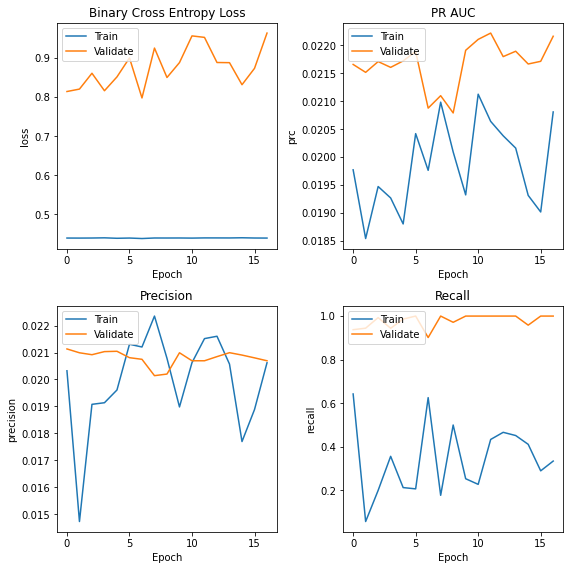

In [17]:
ev.plot_history(history)

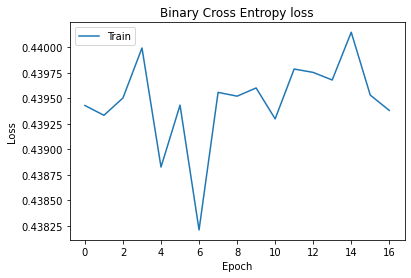

In [18]:
plt.plot(history.history['loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

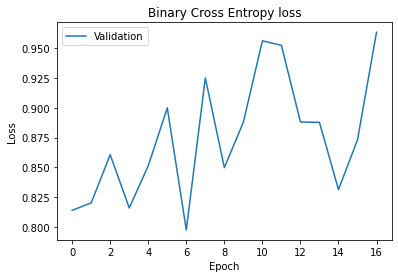

In [19]:
plt.plot(history.history['val_loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validation'], loc='upper left')
plt.show()